This notebook lays out the initial set of analyses performed by RP using multidimensional item response theory (MIRT) on a subset of the UH2 discovery sample.  

For the analyses of the survey data, we have discussed two potential approaches, to be pursued in parallel.  One is to examine the survey results using the standard subscales associated with each survey; that approach is not addressed here.  The second, which I focus on here, is to estimate a set of factors without regard to the inventories from which the surveys come, in essence treating them as a "bag of items".  

This notebook was first developed on the discovery sample.  Because fit of the mirt model was problematic with smaller samples, we chose to fit it to the full discovery sample. The items were cleaned in order to collapse extreme item  responses that occurred less than 40 times across subjects, as well as removing items that had more than 5 missing responses across subjects.



In [1]:
# first, set up our imports and configuration

import os,glob,pickle,sys
import json
import importlib

import pandas
import networkx as nx
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
pandas.set_option('max_colwidth', 100)


%load_ext rpy2.ipython

%matplotlib inline

# this is kludgey but it works
sys.path.append('../utils')
from show_image import showPDF

from utils import get_info,get_behav_data
from metadata_utils import load_metadata
dataset=get_info('dataset')
print('using dataset:',dataset)
basedir=get_info('base_directory')
derived_dir=os.path.join(basedir,'Data/Derived_Data/Combined_12-05-2016')


/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


using dataset: Discovery_12-05-2016


In [2]:
behavdata=get_behav_data(dataset,full_dataset=True)
data=pandas.DataFrame.from_csv('../Data/Derived_Data/Combined_12-05-2016/surveydata_fixed_minfreq40.csv')
survey_metadata = pickle.load(open(os.path.join(basedir,'Data/Derived_Data/Discovery_12-05-2016/survey_metadata.pkl'),'rb'))


Getting datasets...:
 /Users/poldrack/code/Self_Regulation_Ontology/Data/Discovery_12-05-2016
 /Users/poldrack/code/Self_Regulation_Ontology/Data/Validation_12-05-2016


In [3]:
print('Processed the following surveys for %d subjects:'%data.shape[0])
print('data stored in %s'%derived_dir)
print('')
surveyinfo=[]
all_metadata={}
for k in survey_metadata.keys():
    surveyinfo.append([k.replace('_survey',''),len(survey_metadata[k])-1])
    for kk in survey_metadata[k].keys():
        if kk=='MeasurementToolMetadata':
            continue
        all_metadata[kk]=survey_metadata[k][kk]
df=pandas.DataFrame(surveyinfo,columns=['SurveyName','NumberOfItems'])
display(df)
print(df.NumberOfItems.sum(),'items total')


Processed the following surveys for 522 subjects:
data stored in /Users/poldrack/code/Self_Regulation_Ontology/Data/Derived_Data/Combined_12-05-2016



,SurveyName,NumberOfItems
0,theories_of_willpower,12
1,selection_optimization_compensation,48
2,dospert_rp,30
3,dospert_rt,30
4,five_facet_mindfulness,39
5,dospert_eb,30
6,time_perspective,56
7,dickman,23
8,leisure_time_activity,1
9,upps_impulsivity,59


594 items total


### MIRT analyses

I then used the R mirt package to run exploratory multidimensional IRT analyses, using a graded response model with the Metropolis-Hastings Robbins-Monro (MHRM) algorithm so that I could successfully fit the larger models.  In the example shown below, I fit models with dimensionalities from 1 to 10.  I then characterized each dimension by examining the items that had the highest/lowest scores on each one and giving a summary label (which was sometimes difficult, in which case I just used "unknown").  See run_mirt.R for details on how the model was run.





Now let's load in the models from each dimensionality (run on the cluster) and save their latent scores so that we can load them into python and have a look. (this is adapted from summarize_mirt.R)

In [4]:
datfiles=glob.glob('output/*Rdata')
compnums=[int(i.split('/')[1].replace('mirt_','').replace('dims_graded.Rdata','')) for i in datfiles]
compnums.sort()
print(compnums)
if not os.path.exists('mirt_scores'):
    os.mkdir('mirt_scores')
if not os.path.exists('subject_scores'):
    os.mkdir('subject_scores')
    
%load_ext rpy2.ipython
%R require('mirt')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: mirt

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [5]:
%%R -i compnums -o converged,aic,bic
#compnums=c(1,2,3,4,5,6,8,9,10)
converged=array(dim=length(compnums))
aic=array(dim=length(compnums))
bic=array(dim=length(compnums))

for (i in 1:length(compnums)) {
  ncomps=compnums[i]
  load(sprintf('output/mirt_%ddims_graded.Rdata',ncomps))
  converged[i]=m@OptimInfo$converged
  aic[i]=m@Fit$AIC
  bic[i]=m@Fit$BIC

  s=summary(m,verbose=FALSE)
  scores=s$rotF
  write.table(scores,file=sprintf('mirt_scores/mirt_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
  subscores=fscores(m,method='MAP')
  write.table(subscores,file=sprintf('subject_scores/subject_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
}

Plot some convergence statistics for each model - whereas the higher-dimension models did not converge for the previous discovery analyses, all of them converge with the full dataset.

,AIC,BIC,converged
1,563656.645681,571409.858359,1
2,545332.416662,555380.512170,1
3,543970.169844,556308.890513,1
4,535480.857129,550105.945293,1
5,532854.623981,549761.821972,1
6,522887.028154,542072.078305,1
7,524002.621995,545461.266638,1
8,524913.701981,548641.683448,1
9,525935.958820,551929.019445,1
10,529285.565517,557539.447630,1


AIC chooses 6 dimensions
BIC chooses 6 dimensions


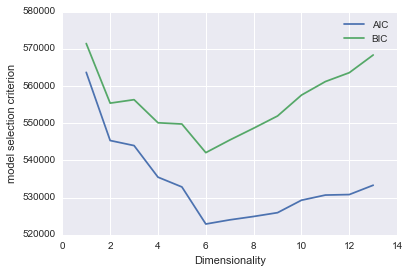

In [54]:
# print out some convergence statistics for each model
df=pandas.DataFrame({'converged':converged,'AIC':aic,'BIC':bic},index=compnums)
display(df)
plt.plot(compnums,aic)
plt.plot(compnums,bic)

plt.xlabel('Dimensionality')
plt.ylabel('model selection criterion')
plt.legend(['AIC','BIC'])
print('AIC chooses %d dimensions'%(numpy.argmin(aic)+1))
print('BIC chooses %d dimensions'%(numpy.argmin(bic)+1))

Now let's look at the results from each model.   First we need to set up a dictionary with the subjective labels NB: These are manually generated using the results from below.

In [130]:
compdesc={}
compdesc[1]=['persistence']
compdesc[2]=['persistence','risk/nonplanning']
compdesc[3]=['persistence','risk/nonplanning','internalizing']
compdesc[4]=['persistence','risk','nonplanning','internalizing']
compdesc[5]=['persistence','risk','nonplanning','internalizing',
            'positive-urgency']
compdesc[6]=['persistence','sensation-seeking','emotion regulation','nonplanning',
            'positive-urgency','past-negative']
compdesc[7]=['positive-urgency','sensation-seeking','risk','persistence',
             'unclear','past-negative','emotion regulation']
compdesc[8]=['positive-urgency','risk/sensation-seeking','nonplanning/risk',
            'planning/future-negative','persistence','past-negative','social risk/self-control',
            'mindfulness']
compdesc[9]=['positive-urgency','physical risk','eating/self-control','gambling',
             'past-negative','social risk','persistence','mindful attention','mindfulness']
compdesc[10]=['positive-urgency','physical risk','past-negative','nonplanning',
              'social risk','eating/self-control','persistence','mindful attention',
              'gambling','future time']

Now let's list the items with top positive and negative scores for each latent dimension, along with the subjective label.

In [131]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;


<IPython.core.display.Javascript object>

In [132]:
compnums

range(1, 9)

In [133]:
mirt_scores={}
for c in range(6,10):
    ncomps=compnums[c]
    scdata=pandas.read_csv('mirt_scores/mirt_scores_%ddims.tsv'%ncomps,
                         delimiter='\t',header=None,names=['itemname']+['score%d'%int(i+1) for i in range(ncomps)])
    scdata=scdata[scdata.itemname != 'X']
    mirt_scores[ncomps]=scdata
    print('')
    for d in range(ncomps):
        print('%d Components: Dimension %d (%s)'%(ncomps,d+1,compdesc[ncomps][d]))
        cdata=scdata.sort_values(by='score%d'%int(d+1))
        lowdata=cdata.iloc[:3,[0,d+1]]
        highdata=cdata.iloc[-3:,[0,d+1]]
        data_show=pandas.concat([lowdata,highdata])
        itemtext=[]
        for item in data_show['itemname']:
            itemtext.append(all_metadata[item]['Description'])
        data_show['itemtext']=itemtext
        display(data_show)    


7 Components: Dimension 1 (positive-urgency)


,itemname,score1,itemtext
510,upps_impulsivity_survey.31,-0.849725,Others would say I make bad choices when I am extremely happy about something.
525,upps_impulsivity_survey.46,-0.837606,"When overjoyed, I feel like I cant stop myself from going overboard."
520,upps_impulsivity_survey.41,-0.810347,"When I get really happy about something, I tend to do things that can have bad consequences."
308,mpq_control_survey.15,0.405797,I do the first thing that comes to mind.
65,brief_self_control_survey.13,0.422419,"Sometimes I can't stop myself from doing something, even if I know it is wrong."
66,brief_self_control_survey.14,0.491045,I often act without thinking through all the alternatives.


7 Components: Dimension 2 (sensation-seeking)


,itemname,score2,itemtext
270,impulsive_venture_survey.20,-0.811764,Do you sometimes like doing things that are a bit frightening?
262,impulsive_venture_survey.12,-0.778730,Do you welcome new and exciting experiences and sensations even if they are a little frightening...
254,impulsive_venture_survey.04,-0.775754,Do you quite enjoy taking risks?
304,mpq_control_survey.10,0.382030,I do things on the spur of the moment.
307,mpq_control_survey.14,0.449829,I am a spontaneous person.
306,mpq_control_survey.13,0.475496,I am cautious person.


7 Components: Dimension 3 (risk)


,itemname,score3,itemtext
265,impulsive_venture_survey.15,-0.548595,Do you often do things on the spur of the moment?
125,dospert_rp_survey.09,-0.522784,Betting a day's income at a high-stake poker game.
126,dospert_rp_survey.10,-0.495051,Having an affair with a married man/woman.
96,dospert_eb_survey.10,0.444415,Having an affair with a married man/woman.
95,dospert_eb_survey.09,0.449820,Betting a day's income at a high-stake poker game.
116,dospert_eb_survey.30,0.466079,Leaving your young children alone at home while running an errand.


7 Components: Dimension 4 (persistence)


,itemname,score4,itemtext
507,upps_impulsivity_survey.28,-0.653470,I finish what I start.
494,upps_impulsivity_survey.15,-0.646209,Unfinished tasks really bother me.
484,upps_impulsivity_survey.05,-0.640721,I generally like to see things through to the end.
434,time_perspective_survey.11,0.668805,"When I want to achieve something, I set goals and consider specific means for reaching those goals."
348,self_regulation_survey.13,0.672096,I usually keep track of my progress toward my goals.
355,self_regulation_survey.20,0.685454,I set goals for myself and keep track of my progress.


7 Components: Dimension 5 (unclear)


,itemname,score5,itemtext
244,grit_scale_survey.02,-0.453020,New ideas and projects sometimes distract me from previous ones.
246,grit_scale_survey.04,-0.438323,I have been obsessed with a certain idea or project for a short time but later lost interest.
55,brief_self_control_survey.03,-0.399420,I have a hard time breaking bad habits.
52,bis_bas_survey.24,0.427293,It would excite me to win a contest.
48,bis_bas_survey.20,0.444415,I feel worried when I think I have done poorly at something important.
487,upps_impulsivity_survey.08,0.450965,"I have trouble resisting my cravings (for food, cigarettes, etc.)."


7 Components: Dimension 6 (past-negative)


,itemname,score6,itemtext
435,time_perspective_survey.12,-0.668289,"On balance, there is much more good to recall than bad in my past."
239,future_time_perspective_survey.07,-0.634400,I could do anything I want in the future.
449,time_perspective_survey.26,-0.632184,The past has too many unpleasant memories that I prefer not to think about.
440,time_perspective_survey.17,0.642424,Painful past experiences keep being replayed in my mind.
458,time_perspective_survey.35,0.700795,It's hard for me to forget unpleasant images of my youth.
474,time_perspective_survey.51,0.711983,I think about the bad things that have happened to me in the past.


7 Components: Dimension 7 (emotion regulation)


,itemname,score7,itemtext
210,five_facet_mindfulness_survey.17,-0.665731,I have trouble thinking of the right words to express how I feel about things.
216,five_facet_mindfulness_survey.23,-0.638751,"When I have a sensation in my body, its difficult for me to describe it because I cant find the ..."
206,five_facet_mindfulness_survey.13,-0.633875,Its hard for me to find the words to describe what Im thinking.
193,erq_survey.10,0.343568,"When I am feeling <i>negative</i> emotions, I make sure not to express them."
190,erq_survey.07,0.372308,I control my emotions by not expressing them.
186,erq_survey.03,0.403751,I keep my emotions to myself.



8 Components: Dimension 1 (positive-urgency)


,itemname,score1,itemtext
510,upps_impulsivity_survey.31,-0.850392,Others would say I make bad choices when I am extremely happy about something.
525,upps_impulsivity_survey.46,-0.811532,"When overjoyed, I feel like I cant stop myself from going overboard."
520,upps_impulsivity_survey.41,-0.805210,"When I get really happy about something, I tend to do things that can have bad consequences."
308,mpq_control_survey.15,0.355013,I do the first thing that comes to mind.
65,brief_self_control_survey.13,0.375533,"Sometimes I can't stop myself from doing something, even if I know it is wrong."
66,brief_self_control_survey.14,0.438019,I often act without thinking through all the alternatives.


8 Components: Dimension 2 (risk/sensation-seeking)


,itemname,score2,itemtext
255,impulsive_venture_survey.05,-0.775251,Would you enjoy parachute jumping?
262,impulsive_venture_survey.12,-0.760713,Do you welcome new and exciting experiences and sensations even if they are a little frightening...
254,impulsive_venture_survey.04,-0.741265,Do you quite enjoy taking risks?
448,time_perspective_survey.25,0.365749,I take each day as it is rather than try to plan it out.
306,mpq_control_survey.13,0.367653,I am cautious person.
307,mpq_control_survey.14,0.397323,I am a spontaneous person.


8 Components: Dimension 3 (nonplanning/risk)


,itemname,score3,itemtext
265,impulsive_venture_survey.15,-0.521050,Do you often do things on the spur of the moment?
263,impulsive_venture_survey.13,-0.492325,Do you usually think carefully before doing anything?
125,dospert_rp_survey.09,-0.485735,Betting a day's income at a high-stake poker game.
97,dospert_eb_survey.11,0.430493,Passing off somebody elses work as your own.
165,dospert_rt_survey.30,0.441341,Leaving your young children alone at home while running an errand.
116,dospert_eb_survey.30,0.492807,Leaving your young children alone at home while running an errand.


8 Components: Dimension 4 (planning/future-negative)


,itemname,score4,itemtext
496,upps_impulsivity_survey.17,-0.467293,I like to stop and think things over before I do them.
74,dickman_survey.09,-0.439547,I have often missed out on opportunities because I couldn't make up my mind fast enough.
528,upps_impulsivity_survey.49,-0.424811,I usually think carefully before doing anything.
45,bis_bas_survey.17,0.516341,If I think something unpleasant is going to happen I usually get pretty 'worked up.
42,bis_bas_survey.14,0.528477,I feel pretty worried or upset when I think or know somebody is angry at me.
53,bis_bas_survey.25,0.592196,I worry about making mistakes.


8 Components: Dimension 5 (persistence)


,itemname,score5,itemtext
348,self_regulation_survey.13,-0.700113,I usually keep track of my progress toward my goals.
362,self_regulation_survey.28,-0.693639,"Once I have a goal, I can usually plan how to reach it."
355,self_regulation_survey.20,-0.692231,I set goals for myself and keep track of my progress.
489,upps_impulsivity_survey.10,0.564549,I tend to give up easily.
494,upps_impulsivity_survey.15,0.578472,Unfinished tasks really bother me.
484,upps_impulsivity_survey.05,0.598415,I generally like to see things through to the end.


8 Components: Dimension 6 (past-negative)


,itemname,score6,itemtext
435,time_perspective_survey.12,-0.688594,"On balance, there is much more good to recall than bad in my past."
449,time_perspective_survey.26,-0.637521,The past has too many unpleasant memories that I prefer not to think about.
444,time_perspective_survey.21,-0.616323,Happy memories of good times spring readily to mind.
440,time_perspective_survey.17,0.631815,Painful past experiences keep being replayed in my mind.
474,time_perspective_survey.51,0.655255,I think about the bad things that have happened to me in the past.
458,time_perspective_survey.35,0.700227,It's hard for me to forget unpleasant images of my youth.


8 Components: Dimension 7 (social risk/self-control)


,itemname,score7,itemtext
148,dospert_rt_survey.02,-0.512960,Admitting that your tastes are different from those of a friend.
201,five_facet_mindfulness_survey.08,-0.483342,"I can easily put my beliefs, opinions, and expectations into words."
161,dospert_rt_survey.22,-0.461612,Choosing a career that you truly enjoy over a more secure one.
55,brief_self_control_survey.03,0.395216,I have a hard time breaking bad habits.
61,brief_self_control_survey.09,0.425126,People would say that I have iron self-discipline.
54,brief_self_control_survey.02,0.437459,I am good at resisting temptation.


8 Components: Dimension 8 (mindfulness)


,itemname,score8,itemtext
4,bis11_survey.06,-0.516571,I don't pay attention.
13,bis11_survey.15,-0.351075,I say things without thinking.
8,bis11_survey.10,-0.335888,I concentrate easily.
228,five_facet_mindfulness_survey.35,0.743779,I do jobs or tasks automatically without being aware of what Im doing.
295,mindful_attention_awareness_survey.11,0.749601,"I do jobs or tasks automatically, without being aware of what Im doing."
299,mindful_attention_awareness_survey.15,0.762583,I find myself doing things without paying attention.


IndexError: range object index out of range

I then analyzed how the dimensions related across each level of complexity, and created a graph showing how the different components related, which is attached here.  the labels of each node reflect the level of dimensionality, the number of the dimension, and my description of the items associated with the dimension.  the links in the graph are based on the strongest correlation between dimensions across levels. what is very cool is that there is a very orderly relation between dimensions at each level. I save the file out to a GraphML file that I can import into Cytoscape for visualization, as the standard methods in networkx don't do a great job of displaying the graph.



In [134]:
corrs={}
g=nx.DiGraph()
verbose=False
compnums=range(1,9)
scores={}
for ncomps in compnums:
    scores[ncomps]=pandas.read_csv('mirt_scores/mirt_scores_%ddims.tsv'%ncomps,
                        delimiter='\t',header=None)

# first set up all nodes
for i in range(len(compnums)):
    for j in range(compnums[i]):
        xnode='%d-%d'%(compnums[i],j+1)
        assert not xnode in g.nodes()
        g.add_node(xnode)
        g.node[xnode]['level']=compnums[i]
        g.node[xnode]['desc']=compdesc[compnums[i]][j]
        if verbose:
            print('added',xnode,g.node[xnode])

# find strong edges between nodes at each level
for i in range(len(compnums)-1):
    s1=scores[compnums[i]]    

    for j in range(i+1,i+2):
        s2=scores[compnums[j]]
        corrs[(i+1,j+1)]=numpy.zeros((compnums[i],compnums[j]))
        for x in range(compnums[i]):
            xnode='%d-%d'%(compnums[i],x+1)
            for y in range(compnums[j]):
                ynode='%d-%d'%(compnums[j],y+1)
                corrs[(i+1,j+1)][x,y]=numpy.corrcoef(s1.loc[:,x+1],s2.loc[:,y+1])[0,1]
            matchnum=numpy.argmax(numpy.abs(corrs[(i+1,j+1)][x,:]))
            mnode='%d-%d'%(compnums[j],matchnum+1)
            g.add_edge(xnode,'%d-%d'%(compnums[j],matchnum+1))
            g[xnode]['%d-%d'%(compnums[j],matchnum+1)]['weight']=float(corrs[(i+1,j+1)][x,matchnum])


            if verbose:
                print('%d-comp%d: matches %d-comp%d (%0.3f)'%(compnums[i],
                    x+1,compnums[j],matchnum+1,corrs[(i+1,j+1)][x,matchnum]))
                


# for nodes with no inputs, find  largest input and add link
if 1:
    indegree=g.in_degree()
    for k in indegree.keys():
        if indegree[k]>0 or k.split('-')[0]=='1':
            continue
        i,j=[int(x) for x in k.split('-')]
        # get correlations with previous level
        c=corrs[(i-1,i)]
        offset=2
        crow=c[:,i-1]
        matchnum=numpy.argmax(numpy.abs(crow))
        newedge='%d-%d'%(compnums[i-offset],matchnum+1)
        g.add_edge(newedge,k)
        g[newedge][k]['weight']=float(crow[matchnum])
        if verbose:
            print(k,i,j,matchnum,newedge,crow)


nx.write_graphml(g,'relations.graphml')

And here is the nicer version created by hand using Cytoscape.

In [ ]:
showPDF('https://dl.dropboxusercontent.com/u/2441264/mirt_graph.pdf')

### IRT via exploratory factor analysis

These analyses use the irt.fa function from the R psych package to perform exploratory factor analysis.  

In [43]:
%%R -o indices
indices=matrix(nrow=16,ncol=2)

for (ncomps in 1:16) {
  load(sprintf('irtfa_analyses_TACC/irtfa_%ddims.Rdata',ncomps))
  indices[ncomps,1]=irtfa.result$fa$RMSEA[1]
  indices[ncomps,2]=irtfa.result$fa$BIC
  loadings=irtfa.result$fa$loadings
  write.table(loadings,file=sprintf('irtfa_scores/irtfa_scores_%ddims.tsv',ncomps),sep='\t',quote=FALSE,col.names=FALSE)
}

In [44]:
showtable=True
if numpy.max(indices[:,0])>0.1 or showtable:
    print('Check for bad fit')
    df=pandas.DataFrame({'Dimensions':numpy.arange(1,17),'RMSEA':indices[:,0],'BIC':indices[:,1]})
    display(df)
else:
    print('all RMSEA values < 0.1')


Check for bad fit


,BIC,Dimensions,RMSEA
0,-628683.334327,1,0.081118
1,-634517.038563,2,0.067347
2,-635230.753174,3,0.061954
3,-634597.597816,4,0.059132
4,-633455.070318,5,0.057348
5,-632236.670120,6,0.055604
6,-630871.681895,7,0.054128
7,-629445.478423,8,0.052705
8,-627934.152819,9,0.051430
9,-626376.931055,10,0.050197


In [53]:
irtfa_compdesc={}
irtfa_compdesc[1]=['self-control']
irtfa_compdesc[2]=['persistence','impulsivity/risk']
irtfa_compdesc[3]=['persistence','nonplanning','physical risk']
irtfa_compdesc[4]=['persistence','nonplanning','internalizing','physical risk']
irtfa_compdesc[5]=['persistence','nonplanning','internalizing',
    'physical risk','unknown']
irtfa_compdesc[6]=['unknown','nonplanning','physical risk',
             'internalizing','social risk','unknown']
irtfa_compdesc[7]=['manic impulsivity','physical risk','dysfunctional risk',
            'internalizing','persistence','unknown','life impulsivity',
            'mindfulness']
irtfa_compdesc[8]=['manic impulsivity','physical risk','dysfunctional risk',
            'internalizing','persistence','unknown','life impulsivity',
            'mindfulness']

irtfa_compdesc[9]=['manic impulsivity','physical risk','financial risk','internalizing',
             'unknown','life risk','persistence','impulsivity','mindfulness']
irtfa_compdesc[10]=['manic impulsivity','physical risk','financial risk','internalizing',
              'mental energy','life risk','persistence','impulsivity','mindfulness','emotion regulation']

In [54]:


irtfa_scores={}
for c in range(6,9):
    ncomps=c
    scdata=pandas.read_csv('irtfa_scores/irtfa_scores_%ddims.tsv'%ncomps,
                         delimiter='\t',header=None,names=['itemname']+['score%d'%int(i+1) for i in range(ncomps)])
    irtfa_scores[ncomps]=scdata
    print('')
    for d in range(ncomps):
        print('%d Dimensions: Dimension %d (%s)'%(ncomps,d+1,irtfa_compdesc[c][d]))
#        print('%d Components: Dimension %d (%s)'%(ncomps,d+1,compdesc[ncomps][d]))
        cdata=scdata.sort_values(by='score%d'%int(d+1))
        lowdata=cdata.iloc[:3,[0,d+1]]
        highdata=cdata.iloc[-3:,[0,d+1]]
        data_show=pandas.concat([lowdata,highdata])
        itemtext=[]
        for item in data_show['itemname']:
            itemtext.append(all_metadata[item]['Description'])
        data_show['itemtext']=itemtext
        display(data_show)    


6 Dimensions: Dimension 1 (unknown)


,itemname,score1,itemtext
2,eating_survey_11,-0.417943,"When I feel lonely, I console myself by eating."
3,upps_impulsivity_survey_8,-0.415565,"I have trouble resisting my cravings (for food, cigarettes, etc.)."
4,upps_impulsivity_survey_28,-0.406029,I finish what I start.
5,self_regulation_survey_4,0.393883,"It's hard for me to notice when I've 'had enough' (alcohol, food, sweets)."
1,brief_self_control_survey_9,0.419255,People would say that I have iron self-discipline.
0,grit_scale_survey_7,0.430381,I have difficulty maintaining my focus on projects that take more than a few months to complete.


6 Dimensions: Dimension 2 (nonplanning)


,itemname,score2,itemtext
152,mpq_control_survey_14,-0.447092,I am a spontaneous person.
153,mpq_control_survey_15,-0.438088,I do the first thing that comes to mind.
155,mpq_control_survey_10,-0.412741,I do things on the spur of the moment.
147,impulsive_venture_survey_18,0.486750,Do you get so 'carried away' by new and exciting ideas. that you never think of possible snags?
146,dickman_survey_2,0.504683,"Often, I don't spend enough time thinking over a situation before I act."
145,impulsive_venture_survey_7,0.525358,Do you generally do and say things without stopping to think?


6 Dimensions: Dimension 3 (physical risk)


,itemname,score3,itemtext
252,dospert_rp_survey_12,-0.464262,Going down a ski run that is beyond your ability.
257,dospert_rp_survey_18,-0.405117,Driving a car without wearing a seat belt.
258,dospert_rp_survey_25,-0.396880,Bungee jumping off a tall bridge.
254,dospert_rt_survey_21,0.416983,Riding a motorcycle without a helmet.
253,dospert_rt_survey_19,0.418568,Investing 10% of your annual income in a new business venture.
251,dospert_rt_survey_25,0.504296,Bungee jumping off a tall bridge.


6 Dimensions: Dimension 4 (internalizing)


,itemname,score4,itemtext
346,future_time_perspective_survey_7,-0.399423,I could do anything I want in the future.
347,ten_item_personality_survey_6,-0.387699,"Anxious, easily upset."
348,future_time_perspective_survey_8,-0.382588,There is plenty of time left in my life to make new plans.
343,time_perspective_survey_17,0.431826,Painful past experiences keep being replayed in my mind.
342,time_perspective_survey_5,0.431938,I often think of what I should have done differently in my life.
341,time_perspective_survey_35,0.453510,It's hard for me to forget unpleasant images of my youth.


6 Dimensions: Dimension 5 (social risk)


,itemname,score5,itemtext
405,dospert_rp_survey_28,-0.455455,Moving to a city far away from your extended family.
408,dospert_rp_survey_2,-0.379513,Admitting that your tastes are different from those of a friend.
413,dospert_rp_survey_31,-0.307884,Not returning a wallet you found that contains $200.
409,dospert_eb_survey_22,0.362694,Choosing a career that you truly enjoy over a more secure one.
407,dospert_rt_survey_2,0.384192,Admitting that your tastes are different from those of a friend.
406,dospert_rt_survey_8,0.389149,Disagreeing with an authority figure on a major issue.


6 Dimensions: Dimension 6 (unknown)


,itemname,score6,itemtext
489,upps_impulsivity_survey_15,-0.221808,Unfinished tasks really bother me.
494,dospert_eb_survey_30,-0.214336,Leaving your young children alone at home while running an errand.
40,upps_impulsivity_survey_5,-0.196424,I generally like to see things through to the end.
463,bis11_survey_5,0.340714,I am happy-go-lucky.
462,bis_bas_survey_5,0.377675,When I am doing well at something I love to keep at it.
461,bis_bas_survey_15,0.425132,When I see an opportunity for something I like I get excited right away.



7 Dimensions: Dimension 1 (manic impulsivity)


,itemname,score1,itemtext
2,mpq_control_survey_15,-0.456051,I do the first thing that comes to mind.
7,mpq_control_survey_10,-0.431648,I do things on the spur of the moment.
11,mpq_control_survey_14,-0.419965,I am a spontaneous person.
3,bis11_survey_18,0.454496,I act on impulse.
1,impulsive_venture_survey_11,0.469489,Are you an impulsive person?
0,impulsive_venture_survey_7,0.532565,Do you generally do and say things without stopping to think?


7 Dimensions: Dimension 2 (physical risk)


,itemname,score2,itemtext
117,theories_of_willpower_survey_7,-0.435279,"After a strenuous mental activity, you feel energized for further challenging activities."
118,theories_of_willpower_survey_5,-0.417180,"Your mental stamina fuels itself. Even after strenuous mental exertion, you can continue doing m..."
121,upps_impulsivity_survey_10,-0.363731,I tend to give up easily.
123,self_regulation_survey_17,0.338423,I have a hard time setting goals for myself.
120,ten_item_personality_survey_3,0.370615,"Extraverted, enthusiastic."
119,dickman_survey_21,0.373297,People have admired me because I can think quickly.


7 Dimensions: Dimension 3 (dysfunctional risk)


,itemname,score3,itemtext
237,dospert_rp_survey_26,-0.308396,Piloting a small plane.
282,dospert_rp_survey_25,-0.258365,Bungee jumping off a tall bridge.
268,dospert_rp_survey_12,-0.258132,Going down a ski run that is beyond your ability.
212,impulsive_venture_survey_5,0.477667,Would you enjoy parachute jumping?
211,upps_impulsivity_survey_27,0.482289,I would enjoy parachute jumping.
210,upps_impulsivity_survey_37,0.497761,I would like to learn to fly an airplane.


7 Dimensions: Dimension 4 (internalizing)


,itemname,score4,itemtext
260,dospert_eb_survey_10,-0.433040,Having an affair with a married man/woman.
261,dospert_eb_survey_4,-0.403533,Betting a day's income at the horse races.
263,dospert_rt_survey_11,-0.394587,Passing off somebody elses work as your own.
266,dospert_rp_survey_11,0.377127,Passing off somebody elses work as your own.
264,dospert_rp_survey_9,0.388865,Betting a day's income at a high-stake poker game.
262,dospert_rp_survey_15,0.402864,Betting a day's income on the outcome of a sporting event.


7 Dimensions: Dimension 5 (persistence)


,itemname,score5,itemtext
329,time_perspective_survey_35,-0.469376,It's hard for me to forget unpleasant images of my youth.
330,time_perspective_survey_17,-0.444353,Painful past experiences keep being replayed in my mind.
331,time_perspective_survey_51,-0.438721,I think about the bad things that have happened to me in the past.
336,five_facet_mindfulness_survey_15,0.382730,I believe some of my thoughts are abnormal or bad and I shouldnt think that way.
335,future_time_perspective_survey_7,0.396742,I could do anything I want in the future.
333,ten_item_personality_survey_6,0.414145,"Anxious, easily upset."


7 Dimensions: Dimension 6 (unknown)


,itemname,score6,itemtext
399,dospert_rp_survey_28,-0.406117,Moving to a city far away from your extended family.
400,dospert_rp_survey_2,-0.372940,Admitting that your tastes are different from those of a friend.
407,dospert_rp_survey_8,-0.297330,Disagreeing with an authority figure on a major issue.
403,dospert_rt_survey_8,0.366972,Disagreeing with an authority figure on a major issue.
402,dospert_rt_survey_23,0.367825,Speaking your mind about an unpopular issue in a meeting at work.
401,dospert_rt_survey_2,0.370825,Admitting that your tastes are different from those of a friend.


7 Dimensions: Dimension 7 (life impulsivity)


,itemname,score7,itemtext
495,dospert_eb_survey_30,-0.210714,Leaving your young children alone at home while running an errand.
499,erq_survey_3,-0.194608,I keep my emotions to myself.
53,impulsive_venture_survey_35,-0.194528,Do you usually make up your mind quickly?
465,bis11_survey_5,0.325804,I am happy-go-lucky.
464,bis_bas_survey_5,0.347051,When I am doing well at something I love to keep at it.
463,bis_bas_survey_15,0.410010,When I see an opportunity for something I like I get excited right away.



8 Dimensions: Dimension 1 (manic impulsivity)


,itemname,score1,itemtext
5,upps_impulsivity_survey_28,-0.409997,I finish what I start.
10,upps_impulsivity_survey_38,-0.381139,I am a person who always gets the job done.
23,upps_impulsivity_survey_15,-0.346143,Unfinished tasks really bother me.
2,five_facet_mindfulness_survey_6,0.450773,"When I do things, my mind wanders off and Im easily distracted."
1,self_regulation_survey_14,0.460288,I am able to accomplish goals for myself.
0,self_regulation_survey_16,0.475060,"As soon as I see a problem or challenge, I start looking for possible solutions."


8 Dimensions: Dimension 2 (physical risk)


,itemname,score2,itemtext
116,mpq_control_survey_15,-0.475357,I do the first thing that comes to mind.
119,mpq_control_survey_5,-0.430536,I stop and think.
133,mpq_control_survey_4,-0.367603,I think before doing.
117,impulsive_venture_survey_7,0.467140,Do you generally do and say things without stopping to think?
115,impulsive_venture_survey_11,0.481153,Are you an impulsive person?
114,impulsive_venture_survey_13,0.510327,Do you usually think carefully before doing anything?


8 Dimensions: Dimension 3 (dysfunctional risk)


,itemname,score3,itemtext
251,dospert_rp_survey_26,-0.293829,Piloting a small plane.
256,bis_bas_survey_23,-0.273577,I have very few fears compared to my friends.
296,dospert_rp_survey_12,-0.266267,Going down a ski run that is beyond your ability.
221,upps_impulsivity_survey_19,0.480937,I would enjoy water skiing.
220,impulsive_venture_survey_5,0.491061,Would you enjoy parachute jumping?
219,upps_impulsivity_survey_27,0.497884,I would enjoy parachute jumping.


8 Dimensions: Dimension 4 (internalizing)


,itemname,score4,itemtext
278,dospert_rp_survey_11,-0.376740,Passing off somebody elses work as your own.
279,dospert_rp_survey_16,-0.368999,Engaging in unprotected sex.
282,dospert_rp_survey_9,-0.359859,Betting a day's income at a high-stake poker game.
275,dospert_rt_survey_11,0.394149,Passing off somebody elses work as your own.
274,dospert_rt_survey_4,0.401456,Betting a day's income at the horse races.
273,dospert_eb_survey_10,0.481984,Having an affair with a married man/woman.


8 Dimensions: Dimension 5 (persistence)


,itemname,score5,itemtext
340,ten_item_personality_survey_6,-0.389157,"Anxious, easily upset."
341,future_time_perspective_survey_7,-0.380087,I could do anything I want in the future.
342,future_time_perspective_survey_8,-0.378644,There is plenty of time left in my life to make new plans.
337,time_perspective_survey_51,0.427132,I think about the bad things that have happened to me in the past.
336,time_perspective_survey_17,0.431776,Painful past experiences keep being replayed in my mind.
335,time_perspective_survey_35,0.458083,It's hard for me to forget unpleasant images of my youth.


8 Dimensions: Dimension 6 (unknown)


,itemname,score6,itemtext
417,erq_survey_5,-0.232022,"When I am feeling <i>positive</i> emotions, I am careful not to express them."
65,grit_scale_survey_4,-0.203092,I have been obsessed with a certain idea or project for a short time but later lost interest.
57,grit_scale_survey_6,-0.201468,I often set a goal but later choose to pursue a different one.
400,bis_bas_survey_5,0.335666,When I am doing well at something I love to keep at it.
399,eating_survey_11,0.336890,"When I feel lonely, I console myself by eating."
398,bis_bas_survey_15,0.410189,When I see an opportunity for something I like I get excited right away.


8 Dimensions: Dimension 7 (life impulsivity)


,itemname,score7,itemtext
435,theories_of_willpower_survey_5,-0.474982,"Your mental stamina fuels itself. Even after strenuous mental exertion, you can continue doing m..."
436,theories_of_willpower_survey_7,-0.442939,"After a strenuous mental activity, you feel energized for further challenging activities."
437,theories_of_willpower_survey_6,-0.392726,"When you have completed a strenuous mental activity, you cannot start another activity immediate..."
441,dickman_survey_4,0.359156,"I don't like to make decisions quickly, even simple decisions, such as choosing what to wear, or..."
440,dickman_survey_12,0.360647,I am uncomfortable when l have to make up my mind rapidly.
439,dickman_survey_21,0.361909,People have admired me because I can think quickly.


8 Dimensions: Dimension 8 (mindfulness)


,itemname,score8,itemtext
476,dospert_rt_survey_23,-0.363861,Speaking your mind about an unpopular issue in a meeting at work.
477,dospert_rt_survey_8,-0.355998,Disagreeing with an authority figure on a major issue.
478,dospert_rt_survey_29,-0.349940,Starting a new career in your mid-thirties.
480,dospert_rp_survey_17,0.319501,Revealing a friend's secret to someone else.
479,dospert_rp_survey_2,0.337237,Admitting that your tastes are different from those of a friend.
475,dospert_rp_survey_28,0.392103,Moving to a city far away from your extended family.


### compare MIRT and IRTFA results

In [ ]:
for ncomps in range(2,11):
    isc=irtfa_scores[ncomps].sort_values(by='itemname')
    msc=mirt_scores[ncomps].sort_values(by='itemname')
    msc=msc.loc[msc['itemname'].isin(list(isc['itemname']))]
    assert all(msc.itemname==isc.itemname)
    for i in range(ncomps):
        irtfadata=isc.iloc[:,i+1]

        for j in range(ncomps):
            mirtdata=msc.iloc[:,j+1]
            print(ncomps,i+1,j+1,numpy.corrcoef(irtfadata,mirtdata)[0,1])

In [ ]:
isc=irtfa_scores[ncomps].sort_values(by='itemname')

### IClust 
Run a similar analysis using iclust from the R Psych package (based on Revelle, 1979)

In [ ]:
surveydata=pandas.read_csv('surveydata.csv',index_col='worker')
varnames=list(surveydata.columns)
surveydata.shape
len(varnames)

In [ ]:
%%R -i surveydata,varnames
library(psych)
df=data.frame(surveydata)
names(df)=varnames
pdf(file='iclust_surveys.pdf',width=16, height=16)
iclust(df)
dev.off()

### Cross-validation analyses

In parallel to these I have also run a set of analyses where I perform cross-validation by estimating the model on split halves of the data and then compute the log-likelihood of the held-out data given the model; this is a standard method in machine learning for estimating the appropriate model order in an unbiased way.  

First, we load the output from the crossvalidation analyses that were run on the TACC Wrangler cluster (using run_mirt_cv.R).  There was a complication that arose due to the fact that mirt() works on a full data matrix that expands each item into all possible response values; if there is a response on a particular item that occurs in one dataset but not in another, then this causes a mismatch between models which makes it impossible to assess the likelihood on the held-out data.  My solution to this was to find responses that occurred rarely, and either move them towards the center of the scale (e.g., if there were a small number of "7" responses on a 1-7 scale, change them to "6" responses), or to delete the item (if there were more than two low-frequency responses, or if they occurred in a non-extreme position).  This was performed using cleanup_items_for_mirt_cv.py; the analyses presented here used a minimum response frequency of 8, which resulted in removal of 23 of the 507 original items.  Thus, the data going into the crossvalidation are not exactly the same as the full data analyzed above.


In [ ]:
meanll=numpy.zeros(10)
dimvals=[]
for i in range(1,10):
    files=glob.glob('cvdata/ll_%03d_*'%i)
    if len(files)==0:
        continue
    m=[]
    dimvals.append(i)
    for f in files:
        d=numpy.loadtxt(f)
        m.append(numpy.mean(d))
    meanll[i]=numpy.mean(m)

plt.plot(dimvals,meanll[1:])
plt.xlabel('Number of dimensions')
plt.ylabel('log-likeihood of held-out data')
print('Crossvalidation suggests %d dimensions'%dimvals[numpy.argmax(meanll[1:])])